In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.transform import resize

from tensorflow.keras import datasets, layers, models, callbacks
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

# 1. Wstępne przetwarzanie danych

In [2]:
train_dir = "/kaggle/input/krajobrazy/seg_train/seg_train"
test_dir = "/kaggle/input/krajobrazy/seg_test/seg_test"

x_train = []
y_train = []

x_test = []
y_test = []

folderlist = os.listdir(train_dir);
folderlist.sort();

print(folderlist)

for i in range(0,6):
    print("     "+str(i)+"    ",end="")

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
     0         1         2         3         4         5    

In [3]:
for i, category in enumerate(folderlist):
    pictures = os.listdir(train_dir+"/"+category)
    for picture in pictures:
        img = plt.imread(train_dir+"/"+category+'/{0}'.format(picture),0)
        img_resized = resize(img, (150, 150))  # Zmiana rozmiaru obrazów
        x_train.append(img_resized)
        y_train.append(i)

print("Train data:")
print("x_train: "+str(len(x_train))) 
print("y_train: "+str(len(y_train)))

Train data:
x_train: 14034
y_train: 14034


In [4]:
for i, category in enumerate(folderlist):
    pictures = os.listdir(test_dir+"/"+category)
    for picture in pictures:
        img = plt.imread(test_dir+"/"+category+'/{0}'.format(picture),0)
        img_resized = resize(img, (150, 150))  # Zmiana rozmiaru obrazów
        x_test.append(img_resized)
        y_test.append(i)

print("Test data:")
print("x_test: "+str(len(x_test)))
print("y_test: "+str(len(y_test)))

Test data:
x_test: 3000
y_test: 3000


In [5]:
x_train = np.array(x_train, 'float32')
y_train = np.array(y_train, 'float32')
x_test = np.array(x_test, 'float32')
y_test = np.array(y_test, 'float32')

print(x_train.shape)

(14034, 150, 150, 3)


In [6]:
x_train_norm = (x_train - np.min(x_train)) / (np.max(x_train) - np.min(x_train)) * 255.0
x_train_norm = x_train_norm / 255.0

x_test_norm = (x_test - np.min(x_test)) / (np.max(x_test) - np.min(x_test)) * 255.0
x_test_norm = x_test_norm / 255.0

In [7]:
y_train_oneHot = to_categorical(y_train, num_classes=6)
y_test_oneHot = to_categorical(y_test,num_classes=6)

# 2. Tworzenie modeli z ewentualną modyfikacją danych

## 2.1 Model Prosty

In [ ]:
model_simple = models.Sequential()
model_simple.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model_simple.add(layers.MaxPooling2D((2, 2)))

model_simple.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_simple.add(layers.Dropout(0.4))
model_simple.add(layers.MaxPooling2D((2, 2)))

model_simple.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_simple.add(layers.Dropout(0.4))
model_simple.add(layers.MaxPooling2D((2, 2)))

model_simple.add(layers.Flatten())
model_simple.add(layers.Dense(512, activation='relu'))
model_simple.add(layers.Dropout(0.4))
model_simple.add(layers.Dense(len(folderlist), activation='softmax'))

model_simple.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
batchSize = 32
epochsNum = 30

stopEarly = EarlyStopping(monitor='val_accuracy' , patience=5, restore_best_weights=True)

history_simple = model_simple.fit(x_train_norm,
                   y_train_oneHot,
                   batch_size=batchSize,
                   shuffle=True,
                   epochs=epochsNum,
                   validation_data=(x_test_norm, y_test_oneHot),
                   callbacks=[stopEarly])

In [ ]:
model_simple.save("zapisane/model_simple.h5")
model_simple.save("zapisane/model_simple.keras")

## 2.2 Model prosty z dodatkową warstwą i innymi parametrami

In [ ]:
model_bigger = models.Sequential()
model_bigger.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model_bigger.add(layers.MaxPooling2D((2, 2)))

model_bigger.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_bigger.add(layers.MaxPooling2D((2, 2)))
model_bigger.add(layers.Dropout(0.3))

model_bigger.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_bigger.add(layers.MaxPooling2D((2, 2)))
model_bigger.add(layers.Dropout(0.3))

model_bigger.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_bigger.add(layers.MaxPooling2D((2, 2)))
model_bigger.add(layers.Dropout(0.3))

model_bigger.add(layers.Flatten())
model_bigger.add(layers.Dense(512, activation='relu'))
model_bigger.add(layers.Dropout(0.4))
model_bigger.add(layers.Dense(6, activation='softmax'))

model_bigger.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
batchSize = 32
epochsNum = 50

stopEarly = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_bigger = model_bigger.fit(x_train_norm,
                           y_train_oneHot,
                           batch_size=batchSize,
                           shuffle=True,
                            epochs=epochsNum,
                            validation_data=(x_test_norm, y_test_oneHot),
                            callbacks=[stopEarly])

In [ ]:
model_bigger.save("zapisane/model_bigger.h5")
model_bigger.save("zapisane/model_bigger.keras")

## 2.3 Model z modyfikacją zdjęć

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.08,
    height_shift_range=0.08,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(x_train)

In [ ]:
model_modify = models.Sequential()

model_modify.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model_modify.add(layers.MaxPooling2D((2, 2)))

model_modify.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_modify.add(layers.Dropout(0.3))
model_modify.add(layers.MaxPooling2D((2, 2)))

model_modify.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_modify.add(layers.Dropout(0.3))
model_modify.add(layers.MaxPooling2D((2, 2)))

model_modify.add(layers.Flatten())
model_modify.add(layers.Dense(512, activation='relu'))
model_modify.add(layers.Dropout(0.3))
model_modify.add(layers.Dense(len(folderlist), activation='softmax'))

model_modify.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
batchSize = 32
epochsNum = 65

stopEarly = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Trening modelu
history_modify = model_modify.fit(datagen.flow(x_train_norm, y_train_oneHot, batch_size=32),
                           shuffle=True,
                            epochs=epochsNum,
                            validation_data=(x_test, y_test_oneHot),
                            callbacks=[stopEarly])

In [ ]:
model_modify.save("zapisane/model_modify.h5")
model_modify.save("zapisane/model_modify.keras")

## 2.4 Model z modyfikacją zdjęć i warstwą BatchNormalization // na razie nie ruszać - za duża wartość val_loss

In [ ]:
model_modify_batch = models.Sequential()

model_modify_batch.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model_modify_batch.add(layers.BatchNormalization())
model_modify_batch.add(layers.MaxPooling2D((2, 2)))

model_modify_batch.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_modify_batch.add(layers.Dropout(0.3))
model_modify_batch.add(layers.BatchNormalization())
model_modify_batch.add(layers.MaxPooling2D((2, 2)))

model_modify_batch.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_modify_batch.add(layers.Dropout(0.3))
model_modify_batch.add(layers.BatchNormalization())
model_modify_batch.add(layers.MaxPooling2D((2, 2)))

model_modify_batch.add(layers.Flatten())
model_modify_batch.add(layers.Dense(512, activation='relu'))
model_modify_batch.add(layers.Dropout(0.3))
model_modify_batch.add(layers.BatchNormalization())
model_modify_batch.add(layers.Dense(6, activation='softmax'))

model_modify_batch.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
batchSize = 32
epochsNum = 50

stopEarly = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Trening modelu
history = model_modify_batch.fit(datagen.flow(x_train_norm, y_train_oneHot, batch_size=32),
                           shuffle=True,
                            epochs=epochsNum,
                            validation_data=(x_test, y_test_oneHot),
                            callbacks=[stopEarly])

In [ ]:
model_modify_batch.save("zapisane/model_modify_batch.h5")
model_modify_batch.save("zapisane/model_modify_batch.keras")

## 2.5 Model prosty wykorzystujący Transformatę Fouriera

In [8]:
x_train_gray = np.mean(x_train_norm, axis=-1)
x_test_gray = np.mean(x_test_norm, axis=-1)

def fft_batch(images, batch_size=100):
    fft_images = []
    for i in range(0, len(images), batch_size):
        batch = images[i:i + batch_size]
        fft_batch = np.fft.fftshift(np.fft.fft2(batch), axes=(-2, -1))
        fft_batch = np.abs(fft_batch)  # Wartości bezwzględne
        fft_batch /= np.max(fft_batch, axis=(-2, -1), keepdims=True)
        fft_images.append(np.abs(fft_batch))  # Użycie wartości bezwzględnej
    return np.concatenate(fft_images, axis=0)

In [9]:
x_train_fft = fft_batch(x_train_gray)
x_test_fft = fft_batch(x_test_gray)

In [10]:
model_simple_fft = models.Sequential()

model_simple_fft.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model_simple_fft.add(layers.MaxPooling2D((2, 2)))

model_simple_fft.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_simple_fft.add(layers.Dropout(0.3))
model_simple_fft.add(layers.MaxPooling2D((2, 2)))

model_simple_fft.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_simple_fft.add(layers.Dropout(0.3))
model_simple_fft.add(layers.MaxPooling2D((2, 2)))

model_simple_fft.add(layers.Flatten())
model_simple_fft.add(layers.Dense(512, activation='relu'))
model_simple_fft.add(layers.Dropout(0.3))
model_simple_fft.add(layers.Dense(6, activation='softmax'))

model_simple_fft.compile(optimizer='adam',
                     loss=tf.keras.losses.categorical_crossentropy,
                     metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
batchSize = 32
epochsNum = 50

stopEarly = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Trening modelu
history = model_simple_fft.fit(x_train_fft,
                               y_train_oneHot,
                               batch_size=batchSize,
                               shuffle=True,
                                epochs=epochsNum,
                                validation_data=(x_test_fft, y_test_oneHot),
                                callbacks=[stopEarly])

Epoch 1/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 469s 1s/step - accuracy: 0.3730 - loss: 1.4248 - val_accuracy: 0.6313 - val_loss: 0.9591
Epoch 2/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 470s 1s/step - accuracy: 0.6539 - loss: 0.8788 - val_accuracy: 0.6490 - val_loss: 0.9228
Epoch 3/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 487s 1s/step - accuracy: 0.6918 - loss: 0.7881 - val_accuracy: 0.6920 - val_loss: 0.7936
Epoch 4/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 501s 1s/step - accuracy: 0.7031 - loss: 0.7428 - val_accuracy: 0.6930 - val_loss: 0.8182
Epoch 5/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 449s 1s/step - accuracy: 0.7209 - loss: 0.7015 - val_accuracy: 0.7213 - val_loss: 0.7210
Epoch 6/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 445s 1s/step - accuracy: 0.7288 - loss: 0.6849 - val_accuracy: 0.7130 - val_loss: 0.7600
Epoch 7/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 449s 1s/step - accuracy: 0.7213 - loss: 0.6876 - val_accuracy: 0.7120 - val_loss: 0.7564
Epoch 8/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 448s 1s/step - accuracy: 0.7348 - loss: 0.6642 - val_accu

In [13]:
model_simple_fft.save("zapisane/model_simple_fft.h5")
model_simple_fft.save("zapisane/model_simple_fft.keras")
model_simple_fft.save("/kaggle/working/model_simple_fft.h5")
model_simple_fft.save("/kaggle/working/model_simple_fft.keras")


## 2.6 AlexNet

In [ ]:
for i, category in enumerate(folderlist):
    pictures = os.listdir(train_dir+"/"+category)
    for picture in pictures:
        img = plt.imread(train_dir+"/"+category+'/{0}'.format(picture),0)
        img_resized = resize(img, (227, 227))  # Zmiana rozmiaru obrazów
        x_train.append(img_resized)
        y_train.append(i)

print("Train data:")
print("x_train: "+str(len(x_train))) 
print("y_train: "+str(len(y_train)))

In [ ]:
for i, category in enumerate(folderlist):
    pictures = os.listdir(test_dir+"/"+category)
    for picture in pictures:
        img = plt.imread(test_dir+"/"+category+'/{0}'.format(picture),0)
        img_resized = resize(img, (227, 227))  # Zmiana rozmiaru obrazów
        x_test.append(img_resized)
        y_test.append(i)

print("Test data:")
print("x_test: "+str(len(x_test)))
print("y_test: "+str(len(y_test)))

In [ ]:
model_AlexNet = models.Sequential()
    
model_AlexNet.add(layers.Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=(227, 227, 3)))
model_AlexNet.add(layers.BatchNormalization())
model_AlexNet.add(layers.MaxPooling2D((3, 3), strides=2))
    
model_AlexNet.add(layers.Conv2D(256, (5, 5), strides=1, padding='same', activation='relu'))
model_AlexNet.add(layers.BatchNormalization())
model_AlexNet.add(layers.MaxPooling2D((3, 3), strides=2))
    
model_AlexNet.add(layers.Conv2D(384, (3, 3), strides=1, padding='same', activation='relu'))
model_AlexNet.add(layers.Conv2D(384, (3, 3), strides=1, padding='same', activation='relu'))
model_AlexNet.add(layers.Conv2D(256, (3, 3), strides=1, padding='same', activation='relu'))
model_AlexNet.add(layers.MaxPooling2D((3, 3), strides=2))
    
model_AlexNet.add(layers.Flatten())
 
model_AlexNet.add(layers.Dense(4096, activation='relu'))
model_AlexNet.add(layers.Dropout(0.5))

model_AlexNet.add(layers.Dense(4096, activation='relu'))
model_AlexNet.add(layers.Dropout(0.5))

model_AlexNet.add(layers.Dense(6, activation='softmax'))

In [ ]:
model_AlexNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

batchSize = 32
epochsNum = 65

stopEarly = EarlyStopping(monitor='val_accuracy' , patience=5, restore_best_weights=True)

history = model_AlexNet.fit(x_train_norm,
                   y_train_oneHot,
                   batch_size=batchSize,
                   shuffle=True,
                   epochs=epochsNum,
                   validation_data=(x_test_norm, y_test_oneHot),
                   callbacks=[stopEarly])

In [ ]:
model_AlexNet.save("zapisane/model_AlexNet.h5")
model_AlexNet.save("zapisane/model_AlexNet.keras")

# 3. Wyniki uczenia poszczególnych modeli

In [ ]:
plot_training_history(history_simple, filename='training_history_model_simple.png') 

In [14]:
import matplotlib.pyplot as plt

def plot_accuracy(epochsNum, acc, val_acc, filename=None):
    plt.figure(figsize=(6, 4))
    plt.plot(epochsNum, acc, 'r', label="Train accuracy")
    plt.plot(epochsNum, val_acc, 'b', label="Validation accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title("Training and Validation Accuracy")
    plt.legend(loc='lower right')
    plt.grid(True)

    if filename:
        plt.savefig(filename)
    plt.show()

def plot_loss(epochsNum, loss, val_loss, filename=None):
    plt.figure(figsize=(6, 4))
    plt.plot(epochsNum, loss, 'r', label="Train loss")
    plt.plot(epochsNum, val_loss, 'b', label="Validation loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title("Training and Validation Loss")
    plt.legend(loc='upper right')
    plt.grid(True)

    if filename:
        plt.savefig(filename)
    plt.show()

def plot_training_history(history, accuracy_filename=None, loss_filename=None):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochsNum = range(1, len(acc) + 1)

    # Plot accuracy
    plot_accuracy(epochsNum, acc, val_acc, accuracy_filename)
    
    # Plot loss
    plot_loss(epochsNum, loss, val_loss, loss_filename)


In [ ]:
plot_training_history(history_bigger, accuracy_filename='accuracy_training_history_model_bigger.png', loss_filename='loss_training_history_model_bigger.png') 

In [ ]:
plot_training_history(history_simple, accuracy_filename='accuracy_training_history_model_simple.png', loss_filename='loss_training_history_model_simple.png') 

In [ ]:
plot_training_history(history_modify, accuracy_filename='accuracy_training_history_model_modify.png', loss_filename='loss_training_history_model_modify.png') 

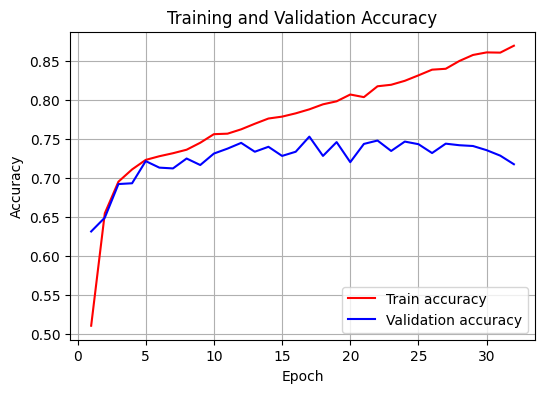

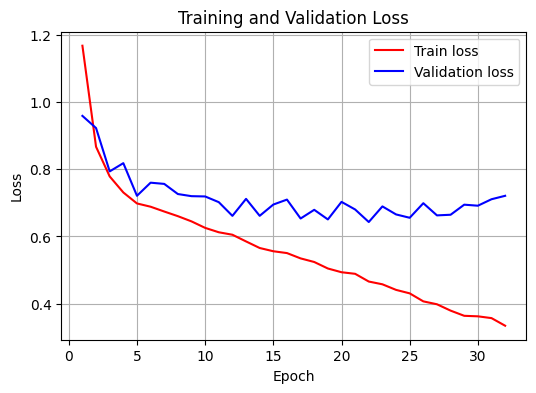

In [15]:
plot_training_history(history, accuracy_filename='accuracy_training_history_model_fft.png', loss_filename='loss_training_history_model_fft.png') 